In [1]:
import numpy as np
import sys

IN_COLAB = "google.colab" in sys.modules

# Import modules

In [2]:
if IN_COLAB:
    !apt install swig
    !pip install stable_baselines3[extra] box2d box2d-kengz comet_ml

In [1]:
import comet_ml as cml
import torch
import gym
import stable_baselines3 as sb3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common import callbacks, env_util
import stable_baselines3.common.logger as logger

D:\PythonEnvs\rl-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CometCallback(callbacks.BaseCallback):
    def __init__(self, experiment: cml.Experiment, verbose: int = 0):
        super().__init__(verbose)
        self.experiment = experiment

    def _init_callback(self):
        hparams = {"algo": self.model.__class__.__name__} | self.model.__dict__
        self.experiment.log_parameters(hparams)

    def _on_step(self) -> bool:
        for k, v in self.locals.items():
            self.experiment.log_metric(k, v, self.num_timesteps)
        return True

# Setup env

In [2]:
env = env_util.make_vec_env("LunarLander-v2", 4, monitor_dir="logs/train")
# eval_env = Monitor(gym.make("LunarLander-v2"), "logs/eval")

# Set up model

In [3]:
def linear_schedule(initial_value: float):
    """Linear learning rate schedule."""

    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

In [4]:
experiment = cml.Experiment(api_key="", workspace="darthreca")
model = sb3.DQN(sb3.dqn.MlpPolicy,
                env,
                gamma=1,
                learning_starts=1000,
                exploration_fraction=0.5,
                exploration_initial_eps=0.5,
                exploration_final_eps=0.01,
                target_update_interval=10,
                batch_size=64,
                learning_rate=linear_schedule(1e-3),
                seed=42,
                tensorboard_log="./logs/lunar-lander",
                verbose=0)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key  is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/python-sdk/warnings-errors/
COMET ERROR: The given API key  is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/python-sdk/warnings-errors/


# Start learning

In [5]:
model.learn(total_timesteps=10, callback=callbacks.CheckpointCallback(
    save_freq=1000, save_path="checkpoints/lunar_lander", name_prefix="base"
))
env.close()
experiment.end()

ImportError: Trying to log data to tensorboard but tensorboard is not installed.

# Start evaluation

In [21]:
test_env = gym.make("LunarLander-v2")
model = sb3.DQN.load("checkpoints/best_model.zip")

trained_policy_result = evaluate_policy(model, test_env, n_eval_episodes=10, render=True, deterministic=True)
print("Trained model: ", trained_policy_result)
test_env.close()

Trained model:  (-214.962060187757, 99.11594393739212)


In [10]:
test_env.close()

file
logs/lunar-lander/start_learning\eval_0.monitor.csv      AxesSubplot(0.125,0.11;0.775x0.77)
logs/lunar-lander/start_learning\eval_100.monitor.csv    AxesSubplot(0.125,0.11;0.775x0.77)
Name: r, dtype: object

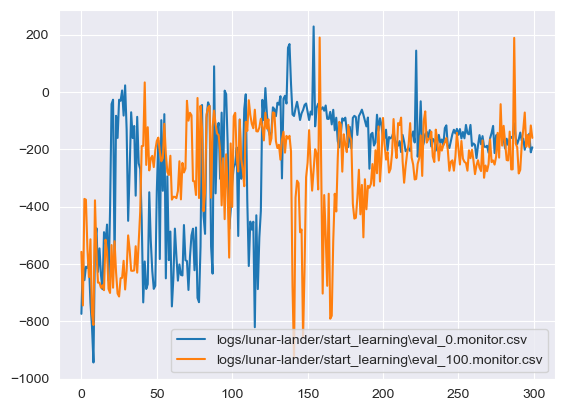

In [16]:
from glob import glob
import pandas as pd

df = pd.DataFrame()
for file in glob("logs/lunar-lander/start_learning/*monitor.csv"):
    current = pd.read_csv(file, header=1)
    current["file"] = file
    df = pd.concat([df, current])
df.groupby("file")["r"].plot(legend=True)